# Facial Recognition with KNN algorithm

## Useful libraries importation

In [43]:
import pandas as pd
import numpy as np
import numpy.linalg as linalg
import matplotlib.pylab as plt

## Face images importation with sklearn

In [44]:
from sklearn.datasets import fetch_lfw_people
lfw_dataset = fetch_lfw_people(min_faces_per_person=200) # To keep people who got 200 images or more
import time as time # To calculate time execution
from sklearn.model_selection import train_test_split # To split data

## Definition of images height, width, vectors and names

In [45]:
img_height = 62 # Images height in pixels
img_width = 47 # Images width in pixels
X = lfw_dataset.data # Line vector of image grey levels
y = lfw_dataset.target # Images labels
names = lfw_dataset.target_names # Peoples name
print(lfw_dataset.images.shape)

(766, 62, 47)


Each photo is encoded in a line vector of 2914 numbers between 0 and 255 (8 bits) which represents pixels grey levels. 766 photos are regrouped in the $X$ matrix. The $X$ matrix have a shape of 766 $\times$ 2914.
The $y$ vector contains photos labels. y=1 if it's a G.W picture and y=0 if it's a C. Powel picture.

The `imshow` function is use to resize the line vector $X[i,:]$ indicating width, height and black and white encoding with the `cmap=plt.cm.gray` option

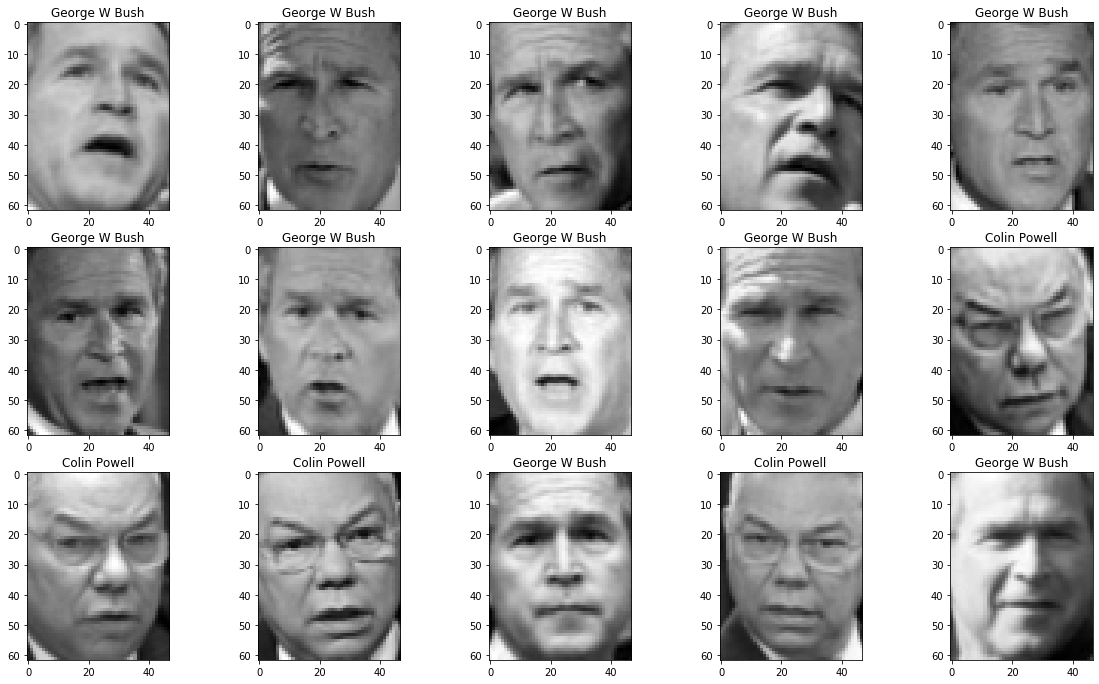

The labels of above images are : [1 1 1 1 1 1 1 1 1 0 0 0 1 0 1] (y=1) for George W Bush and (y=0) for Colin Powell


In [46]:
# We only show the first images of the X dataset, with the corresponding names
plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.imshow(X[i,:].reshape((img_height, img_width)), cmap=plt.plt.cm.gray) # figure's display
    plt.title(names[y[i]])
plt.show()
print(f'The labels of above images are : {y[0:15]} (y=1) for {names[1]} and (y=0) for {names[0]}')

We seperate the dataset randomly in two parts. We train our algorithm with `X_train` and `y_train` then test it on `X_test` and `y_test`.
The `test_size` variable specify the proportion of the test data wished.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

The `distance` function take 2 images (as vectors) and return the euclidian distance between these 2 images.The `distance` function take 2 images (as vectors) and return the euclidian distance between these 2 images.

In [48]:
def distance(I1,I2):
    return np.sqrt(sum((I1-I2)**2))

Prediction from on `X_train` and `y_train`, the images labels of `X_test` by using the *KNN* algorithm. The prediction values are stocked in the y_pred vector.

Then we compare time execution by using the `time` function to display the duration of the algorithm

In [49]:
n_test = X_test.shape[0] # number of individuals in the test sample
n_train = X_train.shape[0] # number of individuals in the train sample
y_pred = np.zeros(n_test) # Initialization of the predictions vector
t1=time.time()
timesArray = np.array([])
for i in range(n_test):
    mini_index=0
    for j in range(n_train):
        if (distance(X_test[i,:],X_train[j,:])<distance(X_test[i,:],X_train[mini_index,:])):
            mini_index=j
    y_pred[i]=y_train[mini_index]
t2=time.time()
print(f'The time execution of the KNN Algorithm with the X_test and the X_train matrix and the distance function is : {t2-t1} seconds')
timesArray = np.append(timesArray,t2-t1)

The time execution of the KNN Algorithm with the X_test and the X_train matrix and the distance function is : 164.9543912410736 seconds


What is the proportion of good classifications ?
The algorithm is more efficient to detect G. W. Bush or C. Powel

In [50]:
goodClassifications = np.array([])
powellDetection = np.array([])
bushDetection = np.array([])
print('Percentage of good classifications :', 1-sum((y_pred-y_test)**2)/n_test)
goodClassifications = np.append(goodClassifications,1-sum((y_pred-y_test)**2)/n_test)
print('Percentage of C. Powel detected :', 1-sum(y_pred[y_test==0])/sum(y_test==0))
powellDetection = np.append(powellDetection,1-sum(y_pred[y_test==0])/sum(y_test==0))
print('Percentage of G. W. Bush detected :', sum(y_pred[y_test==1])/sum(y_test==1))
bushDetection = np.append(bushDetection,sum(y_pred[y_test==1])/sum(y_test==1))

Percentage of good classifications : 0.817391304347826
Percentage of C. Powel detected : 0.6973684210526316
Percentage of G. W. Bush detected : 0.8766233766233766


The images are represented by dots in a 2914 (pixels) space dimension. To find a subspace with a dimension $D < 2914$, we need to realize a ACP (Analyse des composantes principales) PCA.

The reduction of the dimension will allow us to :

* Save data storage space
* Gain computing time for facial recognition
* Improve on average the percentage of good classfication

First we use the `normalize` function which takes a $M$ matrix as an argument and returns a normalised matrix. 

In [51]:
def normalise(M):
    n,p=M.shape
    N=np.zeros((n,p))
    for i in range(p):
        N[:,i]=(M[:,i]-np.mean(M[:,i]))/np.std(M[:,i])# To normalise each row
    return N

Then we use the `correlation` function which takes a $M$ matrix as an argument and return the correlation matrix associated to $M$.

In [52]:
def correlation(M):
    Z= normalise(M)
    n=Z.shape[0]
    return 1/n*np.dot(Z.T,Z)

Finally, we use the `ACP` function which takes a $M$ matrix as an argument and returns the eigenvalues, the eigenvectors and the $P$ matrix.

In [53]:
def acp(M):
    n,p=M.shape
    R= correlation(M)
    valtemp, vectemp = linalg.eigh(R) # valeurs propres et vecteurs propres de la matrice de corrélation
    val = np.sort(valtemp)[::-1] # valeurs propres par ordre décroissant
    index = np.argsort(valtemp)[::-1] # indice du réarrangement des valeurs propres par ordre décroissant
    P=np.zeros((p,p)) # eigenvalue ordered base change matrix propres
    for i in range(p):
        P[:,i]=vectemp[:,index[i]]
    C=np.dot(normalise(M),P)
    return val, P, C
val, P, C = acp(X_train)

In [54]:
valtemp, Ptemp = linalg.eigh(P)
valPropres = np.sort(valtemp)[::-1]
indexsort = np.argsort(valtemp)[::-1]
D=np.diag(valPropres)
#print(D)

### Graphic of the variance explained by the number of components

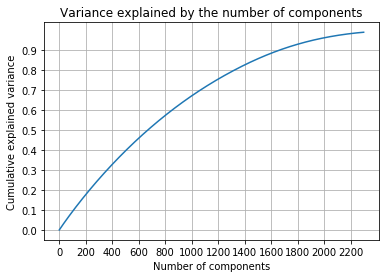

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2300)
X = D
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variance explained by the number of components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 2300, step=200))
plt.grid(True)

### The number $D$ of eigenvalues necessary to explain 95% of the images variance and 90% of the images variance.

In [56]:
test = pca.explained_variance_ratio_.cumsum()
print(f'The number D of eigenvalues necessary to explain 95 % of the images variance is in the range of indexes : {np.where(np.logical_and(test >= 0.95,test <= 0.9509))} the range of values are : {test[np.where(np.logical_and(test >= 0.95,test <= 0.9509))]}')
print(f'The number D of eigenvalues necessary to explain 90 % of the images variance is in the range of indexes : {np.where(np.logical_and(test >= 0.90,test <= 0.9009))} the range of values are : {test[np.where(np.logical_and(test >= 0.90,test <= 0.9009))]}')

The number D of eigenvalues necessary to explain 95 % of the images variance is in the range of indexes : (array([1931, 1932, 1933, 1934, 1935, 1936], dtype=int64),) the range of values are : [0.95000236 0.95015378 0.95030502 0.95045577 0.9506059  0.95075587]
The number D of eigenvalues necessary to explain 90 % of the images variance is in the range of indexes : (array([1671, 1672, 1673, 1674], dtype=int64),) the range of values are : [0.90011978 0.90035403 0.90058788 0.90082146]


Representation of the images generated in the $D$ space first main vectors.

Definition of the $C\_train$ matrix which contains the $D$ first main components for $X\_train$ and definition of $C\_test$ which contains the details of the $X\_test$ in this new space

In [57]:
C_train = C[:,0:D.size]
C_test = np.dot(normalise(X_test),P)[:,0:D.size]
print(np.shape(C_train))
print(np.shape(C_test))
#print('C test matrix \n', C_test,'C train matrix \n' ,C_train)

(536, 2914)
(230, 2914)


Application of the  _**K nearest neighours algorithm**_. Determination of the new computation time, the new percentage of good classifications and the new detection percentage of G.W. Bush and C. Powell

In [58]:
nc_test= C_test.shape[0] # number of individuals in the test sample
nc_train = C_train.shape[0] # number of individuals in the test sample
yc_pred = np.zeros(nc_test) # Initialization of the predictions vector
t1_nc=time.time()
for i in range(n_test):
    mini_index=0
    for j in range(nc_train):
        if (distance(C_test[i,:],C_train[j,:])<distance(C_test[i,:],C_train[mini_index,:])):
            mini_index=j
    yc_pred[i]=y_train[mini_index]
t2_nc=time.time()
print(f'The time execution of the KNN Algorithm with the C_test and the C_train matrix and the distance function is : {t2_nc-t1_nc} seconds')
timesArray= np.append(timesArray,t2_nc-t1_nc)

The time execution of the KNN Algorithm with the C_test and the C_train matrix and the distance function is : 127.33443570137024 seconds


In [59]:
print('Percentage of good classifications :', 1-sum((yc_pred-y_test)**2)/nc_test)
goodClassifications = np.append(goodClassifications,1-sum((yc_pred-y_test)**2)/nc_test)
print('Percentage of C. Powell detected :', 1-sum(yc_pred[y_test==0])/sum(y_test==0))
powellDetection = np.append(powellDetection,1-sum(yc_pred[y_test==0])/sum(y_test==0))
print('Percentage of G.W Bush detected :', sum(yc_pred[y_test==1])/sum(y_test==1))
bushDetection = np.append(bushDetection,sum(yc_pred[y_test==1])/sum(y_test==1))

Percentage of good classifications : 0.8521739130434782
Percentage of C. Powell detected : 0.6973684210526316
Percentage of G.W Bush detected : 0.9285714285714286


Application of the _**KNN algorithm**_  with another measurement of similarities between the images. This  measurement of dissimilarities between the $I1$ and $I2$ is : $1-\mathrm{correlation}(I1,I2)^2$

In [60]:
def dissimilarite(I1,I2):
    return 1-np.corrcoef(I1,I2)[0,1]**2

Application of the _**KNN algorithm**_ with the `dissimilarite` function

In [61]:
nd_test = X_test.shape[0] # number of individuals in the nd test sample
nd_train = X_train.shape[0] # number of individuals in the nd train sample
y_diss_pred = np.zeros(nd_test) # Initialization of the predictions vector
t1_diss=time.time()
for i in range(nd_test):
    mini_index_diss=0
    for j in range(nd_train):
        if (dissimilarite(X_test[i,:],X_train[j,:])<dissimilarite(X_test[i,:],X_train[mini_index,:])):
            mini_index_diss=j
    y_diss_pred[i]=y_train[mini_index_diss]
t2_diss=time.time()
print(f'The time execution of the KNN Algorithm with the X_test and the X_train matrix and the dissimilarite function is : {t2_diss-t1_diss} seconds.')
timesArray = np.append(timesArray,t2_diss-t1_diss)

The time execution of the KNN Algorithm with the X_test and the X_train matrix and the dissimilarite function is : 35.943673849105835 seconds.


In [62]:
print('Percentage of good classifications :', 1-sum((y_diss_pred-y_test)**2)/nd_test)
goodClassifications = np.append(goodClassifications, 1-sum((y_diss_pred-y_test)**2)/nd_test)
print('Percentage of C. Powell detected :', 1-sum(y_diss_pred[y_test==0])/sum(y_test==0))
powellDetection = np.append(powellDetection,1-sum(y_diss_pred[y_test==0])/sum(y_test==0))
print('Percentage of G.W Bush detected :', sum(y_diss_pred[y_test==1])/sum(y_test==1))
bushDetection = np.append(bushDetection,sum(y_diss_pred[y_test==1])/sum(y_test==1))


Percentage of good classifications : 0.6695652173913044
Percentage of C. Powell detected : 0.09210526315789469
Percentage of G.W Bush detected : 0.9545454545454546


Application of the _**KNN Algorithm**_ with the `dissimilarite` function and the main components data

In [63]:
nc_diss_test= C_test.shape[0] # nombre d'individus dans l'échantillon test
nc_diss_train = C_train.shape[0] # nombre d'individus dans l'échantillon train
yc_diss_pred = np.zeros(nc_test) # initialisation du vecteur des prédictions
t1_nc_diss=time.time()
for i in range(nc_diss_test):
    mini_index=0
    for j in range(nc_diss_train):
        if (dissimilarite(C_test[i,:],C_train[j,:])<dissimilarite(C_test[i,:],C_train[mini_index,:])):
            mini_index=j
    yc_diss_pred[i]=y_train[mini_index]
t2_nc_diss=time.time()
print(f'The time execution of the KNN Algorithm with the C_test and the C_train matrix and the dissimilarite function is : {t2_nc_diss-t1_nc_diss} seconds.')
timesArray = np.append(timesArray,t2_nc_diss-t1_nc_diss)

The time execution of the KNN Algorithm with the C_test and the C_train matrix and the dissimilarite function is : 33.29030227661133 seconds.


In [64]:
print('Percentage of good classifications :', 1-sum((yc_diss_pred-y_test)**2)/nc_diss_test)
goodClassifications = np.append(goodClassifications, 1-sum((yc_diss_pred-y_test)**2)/nc_diss_test)
print('Percentage of C. Powell detected :', 1-sum(yc_diss_pred[y_test==0])/sum(y_test==0))
powellDetection = np.append(powellDetection, 1-sum((yc_diss_pred-y_test)**2)/nc_diss_test)
print('Percentage of G.W Bush detected :', sum(yc_diss_pred[y_test==1])/sum(y_test==1))
bushDetection = np.append(bushDetection, sum(yc_diss_pred[y_test==1])/sum(y_test==1))

Percentage of good classifications : 0.8217391304347826
Percentage of C. Powell detected : 0.7105263157894737
Percentage of G.W Bush detected : 0.8766233766233766


### Efficiency difference between the applications of the KNN Algorithm

In [65]:
knnType=['\'KNN Algorithm with the X_test and X_train matrix and the distance function\'','\'KNN Algorithm with the PCA values and distance function\'','\'KNN Algorithm with the X_test and X_train and the dissimilarite function\'','\'KNN Algorithm with the dissimilarite function and the PCA values\'']
def knnEfficiency(testedArray,algoType):
    for i in range(len(testedArray)):
        print(f'The efficiency of the {algoType[i]} is : {testedArray[i]*100}%.')
    print(f'\n The algorithm is the most efficient with the {algoType[np.argmax(testedArray)]}.\n')
    for i in range(len(testedArray)-1):
        print(f'The {i} element have a difference of {(testedArray[i]-testedArray[i+1])*100}% with the {i+1} element.')
    print(f'The 0 element have a difference of {(testedArray[0]-testedArray[len(testedArray)-1])*100}% with the {len(testedArray)} element.')

knnEfficiency(goodClassifications,knnType)


The efficiency of the 'KNN Algorithm with the X_test and X_train matrix and the distance function' is : 81.73913043478261%.
The efficiency of the 'KNN Algorithm with the PCA values and distance function' is : 85.21739130434783%.
The efficiency of the 'KNN Algorithm with the X_test and X_train and the dissimilarite function' is : 66.95652173913044%.
The efficiency of the 'KNN Algorithm with the dissimilarite function and the PCA values' is : 82.17391304347827%.

 The algorithm is the most efficient with the 'KNN Algorithm with the PCA values and distance function'.

The 0 element have a difference of -3.4782608695652195% with the 1 element.
The 1 element have a difference of 18.260869565217387% with the 2 element.
The 2 element have a difference of -15.217391304347828% with the 3 element.
The 0 element have a difference of -0.43478260869566077% with the 4 element.


## Efficiency graph comparison

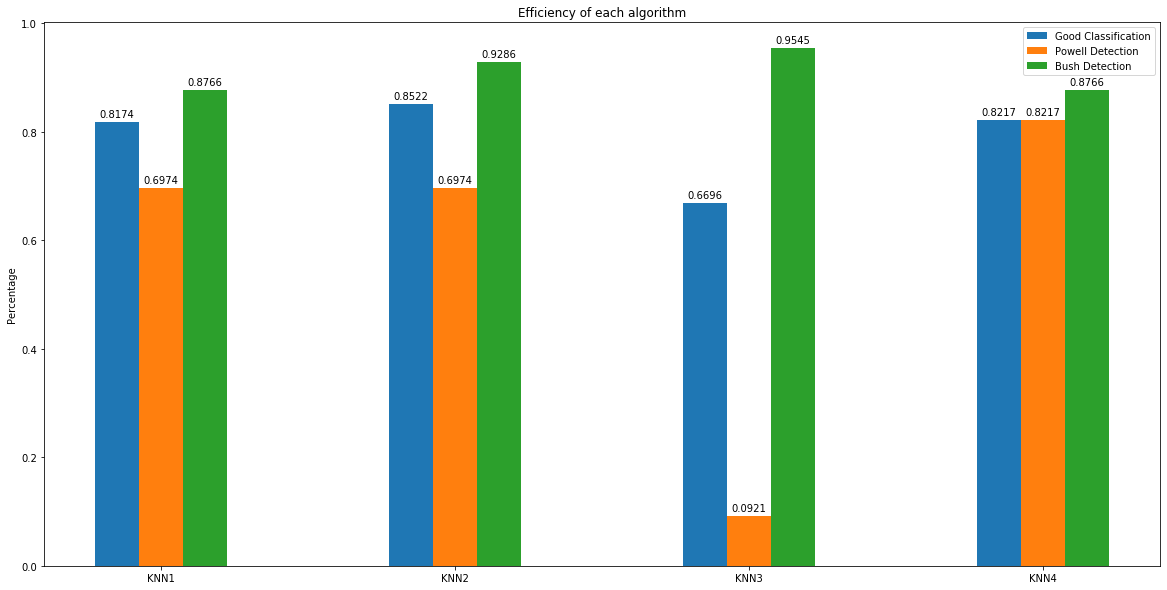

In [76]:
labels = ['KNN1', 'KNN2','KNN3','KNN4']

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
goodClassificationsBar = ax.bar(x + width*2, goodClassifications.round(4), width, label='Good Classification')
powellDetectionBar = ax.bar(x + width*3, powellDetection.round(4), width, label='Powell Detection')
bushDetectionBar = ax.bar(x + width*4, bushDetection.round(4), width, label='Bush Detection')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Efficiency of each algorithm')
ax.set_xticks(x+0.45)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(goodClassificationsBar)
autolabel(powellDetectionBar)
autolabel(bushDetectionBar)



plt.show()

In [67]:
print(f'The fatest algorithm is the {knnType[np.argmin(timesArray)]} and the slowest algorithm is the {knnType[np.argmax(timesArray)]}')

The fatest algorithm is the 'KNN Algorithm with the dissimilarite function and the PCA values' and the slowest algorithm is the 'KNN Algorithm with the X_test and X_train matrix and the distance function'
